In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import time

### 1. Data Loading

In [38]:
# Load the dataset
X_train_df = pd.read_csv('X_train.csv', header = 0) # Keep the first row, which are the titles
X_test_df = pd.read_csv('X_test.csv', header = 0)
X_train = X_train_df.values # Convert to numpy array
X_test = X_test_df.values
y_train = pd.read_csv('y_train.csv', header = 0).squeeze() # Extract Series from single-column DataFrame
y_test = pd.read_csv("y_test.csv", header = 0).squeeze()

# Save the list of feature names
feature_columns = X_train_df.columns.tolist 

### 2. Preprocessing

In [39]:
# Adjust the label to start from 0 to meet the requirement of XGBoost
min_label = min(y_train.min(), y_test.min())
if min_label > 0:
    y_train -= min_label
    y_test -= min_label
    print(f"Adjusted the label to start from 0: {np.unique(y_train)}")

# Standardize to improve the model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

Adjusted the label to start from 0: [0 1 2 3 4 5]


### 3. Model Training

In [40]:
MODEL_CONFIG = {
    'LogisticRegression': {
        'class': LogisticRegression,
        'params': {'max_iter': 1000, 'class_weight': 'balanced'}
    },
    'RandomForest': {
        'class': RandomForestClassifier,
        'params': {'n_estimators': 200, 'max_depth': 10, 'class_weight': 'balanced'}
    },
    'SVM': {
        'class': SVC,
        'params': {'kernel': 'rbf', 'C': 1.0, 'class_weight': 'balanced'}
    },
    'XGBoost': {
        'class': XGBClassifier,
        'params': {'eval_metric': 'logloss'}
    }
}

def train_models(X_train, y_train):
    trained_models = {}
    for model_name, config in MODEL_CONFIG.items():
        print(f"\nTraining {model_name}...")
        start_time = time.time()
        
        # model initialization
        model = config['class'](**config['params'])
        
        # model training
        model.fit(X_train, y_train)
        
        # record the model date
        trained_models[model_name] = {
            'model': model,
            'train_time': time.time() - start_time,
            'feature_importances': getattr(model, 'feature_importances_', None)
        }
        
    return trained_models

trained_models = train_models(X_train_scaled, y_train)



Training LogisticRegression...

Training RandomForest...

Training SVM...

Training XGBoost...


### 4. Prediction and Result Analysis

<Figure size 600x600 with 0 Axes>

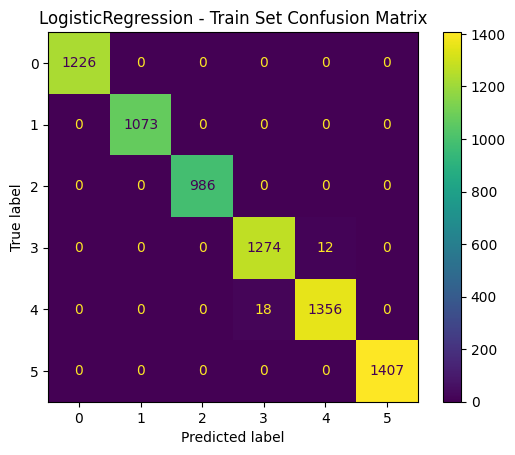

<Figure size 600x600 with 0 Axes>

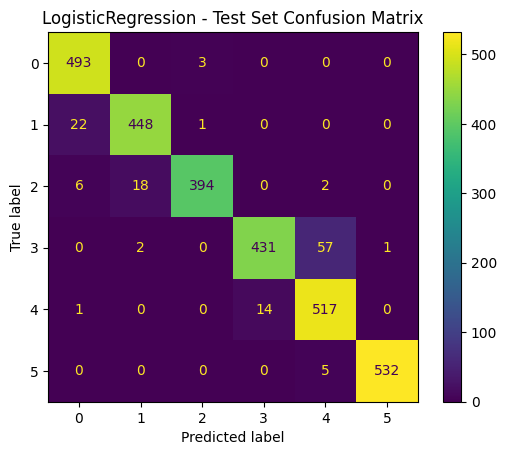

<Figure size 600x600 with 0 Axes>

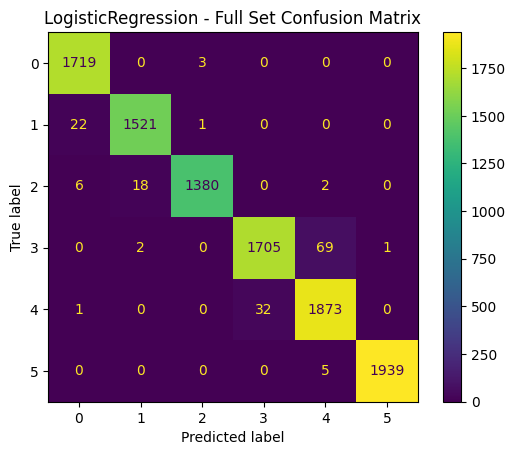

<Figure size 600x600 with 0 Axes>

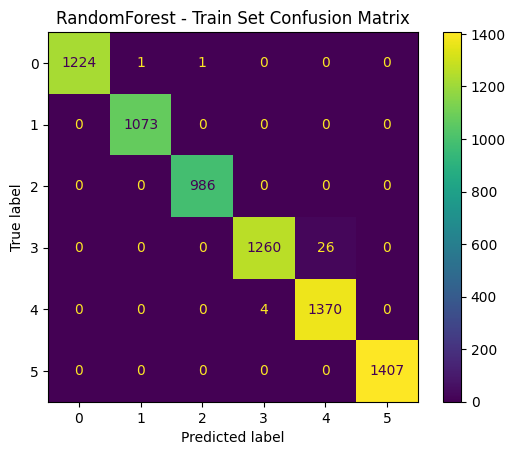

<Figure size 600x600 with 0 Axes>

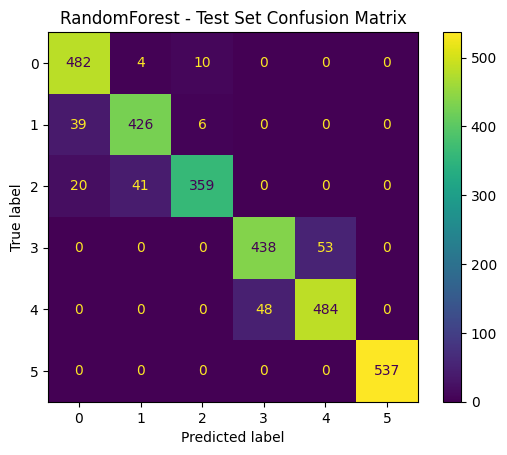

<Figure size 600x600 with 0 Axes>

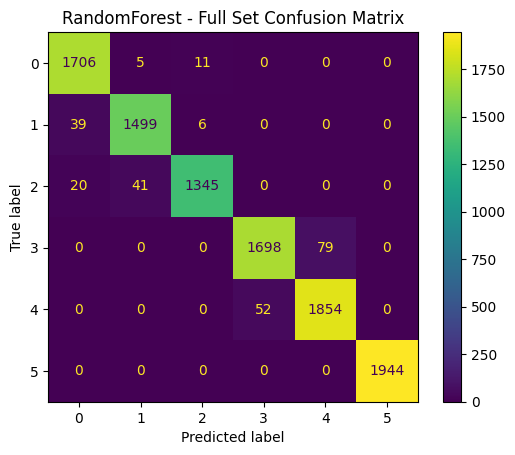

<Figure size 600x600 with 0 Axes>

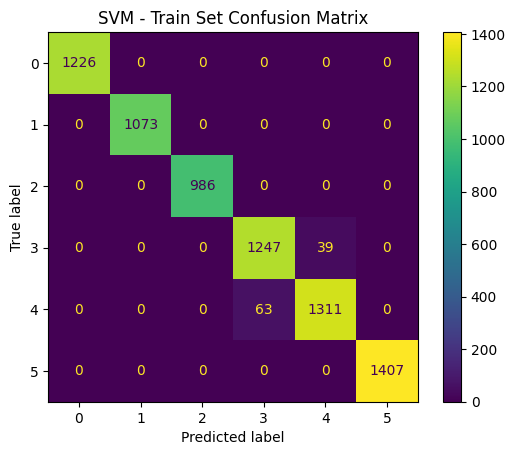

<Figure size 600x600 with 0 Axes>

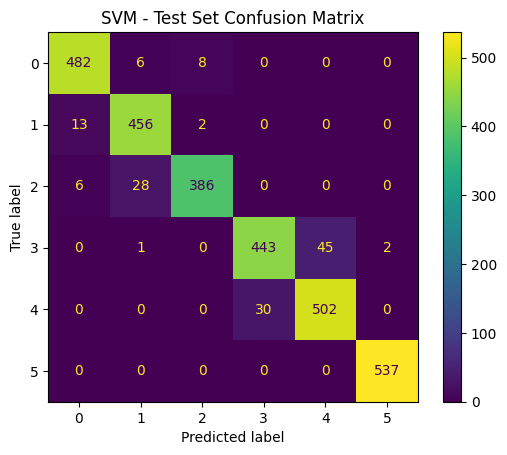

<Figure size 600x600 with 0 Axes>

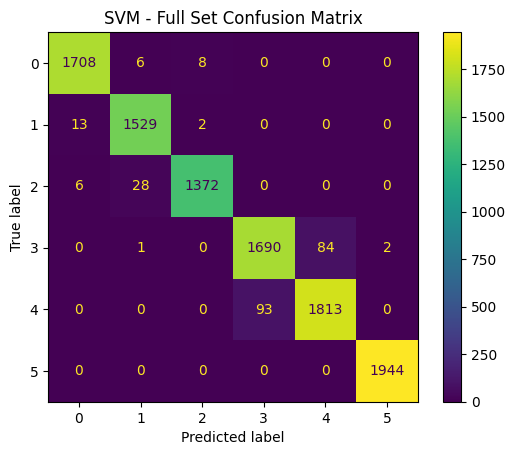

<Figure size 600x600 with 0 Axes>

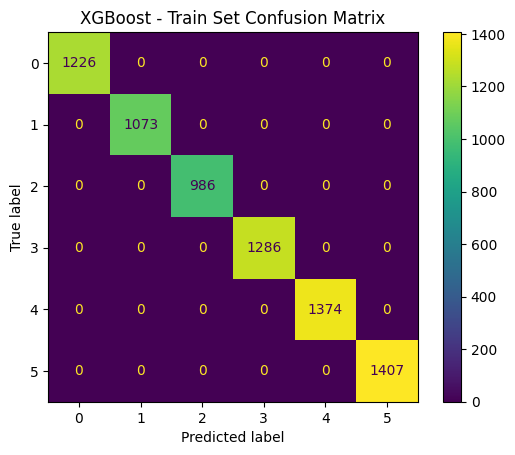

<Figure size 600x600 with 0 Axes>

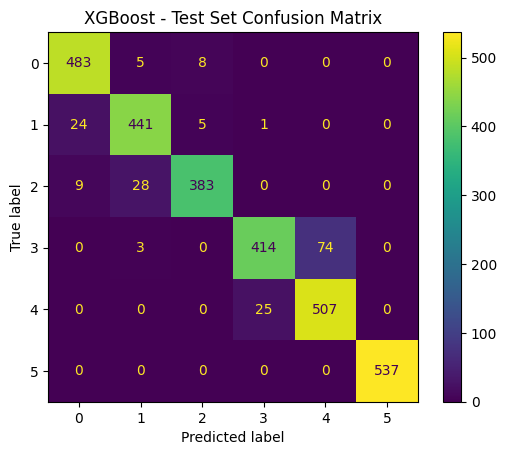

<Figure size 600x600 with 0 Axes>

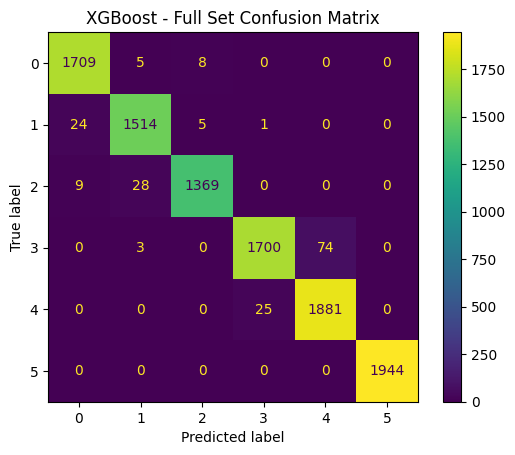


Model Performance Comparison:
                    Train Accuracy  Test Accuracy  Full Accuracy  \
LogisticRegression        0.995919       0.955209       0.984270   
RandomForest              0.995647       0.925008       0.975435   
SVM                       0.986126       0.952155       0.976405   
XGBoost                   1.000000       0.938242       0.982328   

                    Test F1 (Macro)  Full F1 (Macro)  
LogisticRegression         0.955075         0.984445  
RandomForest               0.923225         0.974931  
SVM                        0.951454         0.976824  
XGBoost                    0.937345         0.982068  


In [44]:
def predict_all_sets(model, X_train, X_test):
    # Test the trained model on the training set, testing set and the entire set
    X_full = np.vstack([X_train, X_test])
    return {
        'train': model.predict(X_train),
        'test': model.predict(X_test),
        'full': model.predict(X_full)
    }

# Modified evaluation function to include confusion matrix
def evaluate_model(y_true, y_pred, dataset_name, model_name):
    # Generate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'report': classification_report(y_true, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f'{model_name} - {dataset_name} Set Confusion Matrix')
    plt.show()
    
    return metrics

# Modified comparison function to include full set metrics
def compare_models(results):
    comparison = pd.DataFrame()
    for model_name, data in results.items():
        metrics = {
            'Train Accuracy': data['train']['accuracy'],
            'Test Accuracy': data['test']['accuracy'],
            'Full Accuracy': data['full']['accuracy'],
            'Test F1 (Macro)': data['test']['report']['macro avg']['f1-score'],
            'Full F1 (Macro)': data['full']['report']['macro avg']['f1-score']
        }
        comparison[model_name] = pd.Series(metrics)
    return comparison.T

# Modified prediction and evaluation flow
results = {}
for model_name, model_data in trained_models.items():
    # Get predictions using scaled data
    preds = predict_all_sets(model_data['model'], X_train_scaled, X_test_scaled)
    
    # Create full dataset labels
    y_full = np.concatenate([y_train, y_test])
    
    # Evaluate all sets with visualization
    results[model_name] = {
        'train': evaluate_model(y_train, preds['train'], 'Train', model_name),
        'test': evaluate_model(y_test, preds['test'], 'Test', model_name),
        'full': evaluate_model(y_full, preds['full'], 'Full', model_name)
    }

# Generate comparison table with full set metrics
comparison_table = compare_models(results)
print("\nModel Performance Comparison:")
print(comparison_table)

### 5. Visualization


Generating Visualizations...


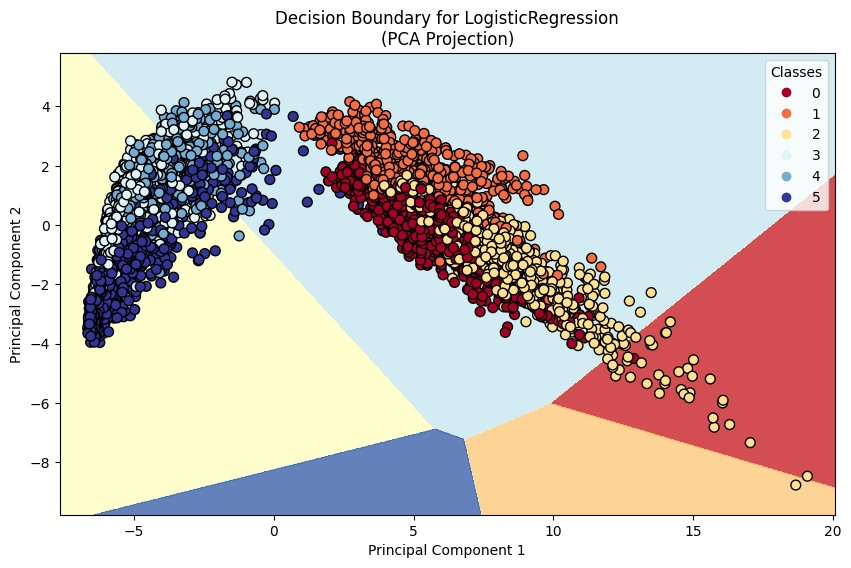

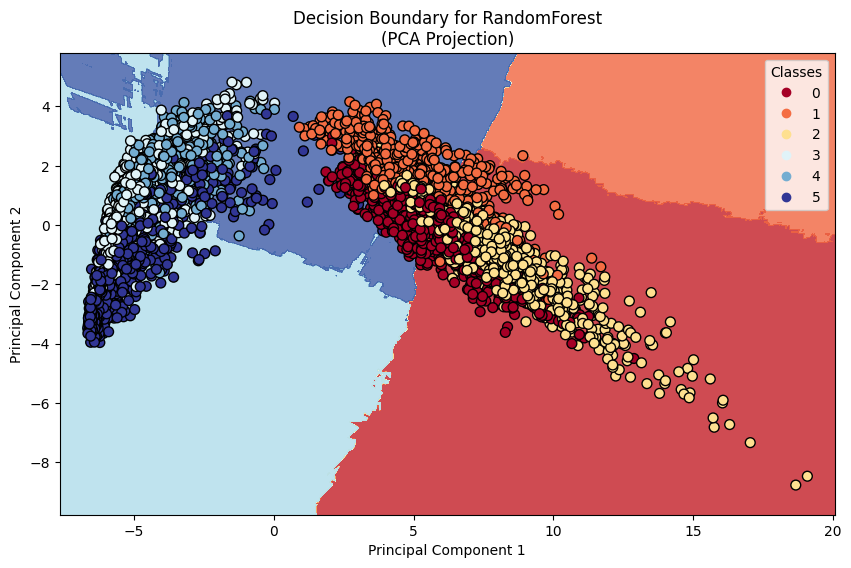

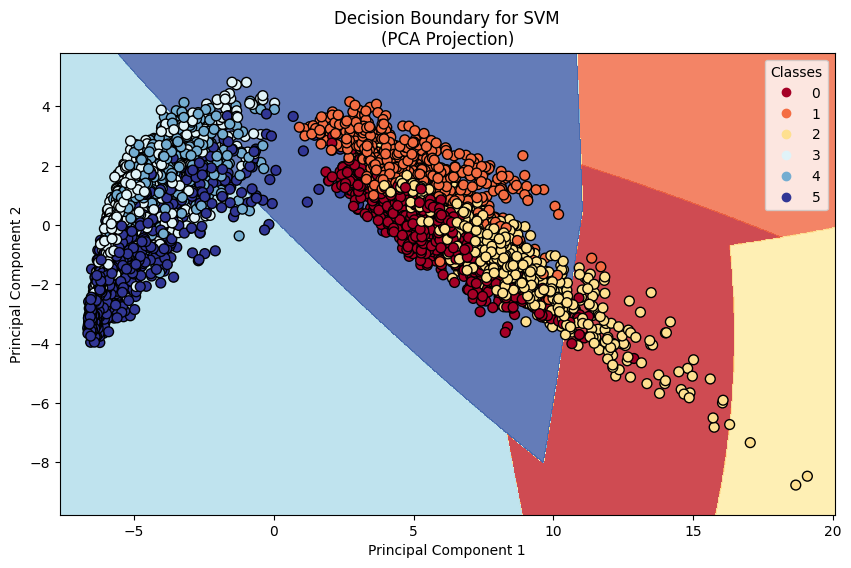

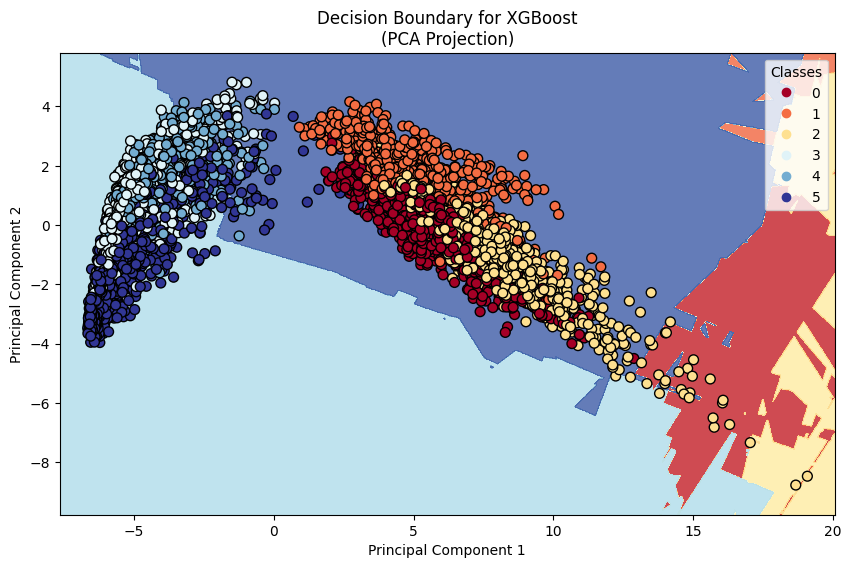

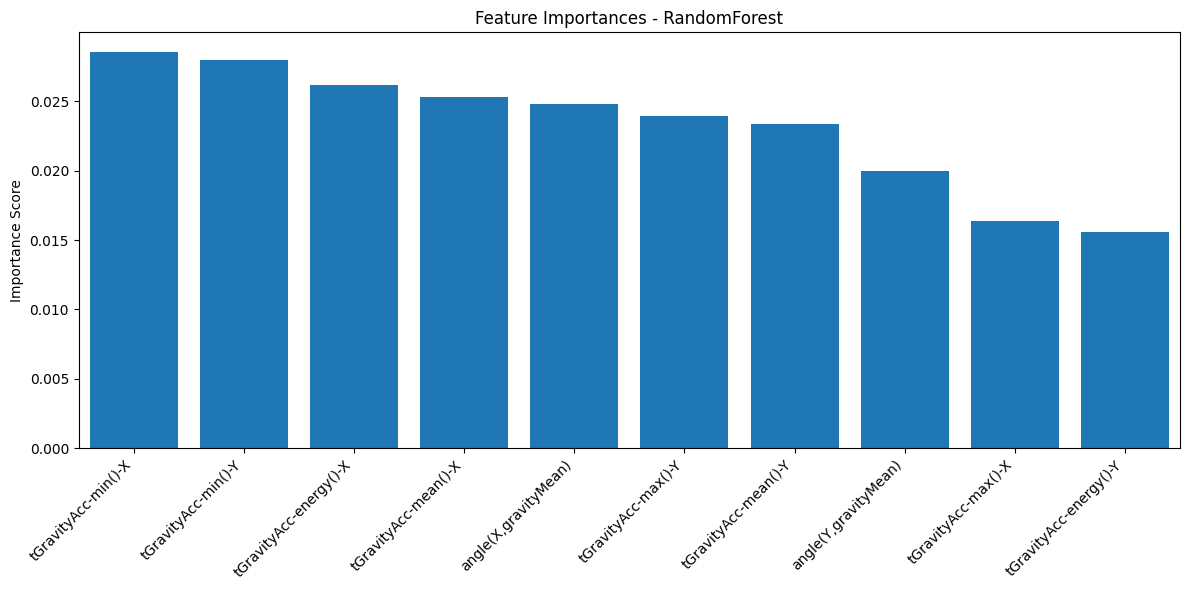

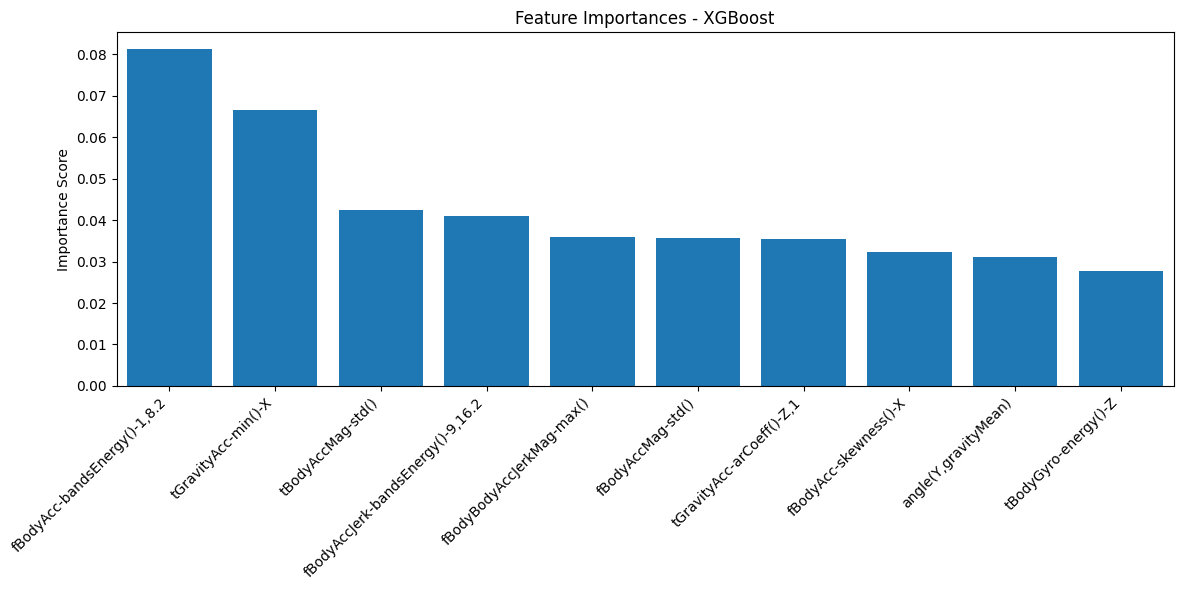

In [46]:
# Fix feature_columns definition (correct the typo)
feature_columns = X_train_df.columns.tolist()

# Visualize Decision Boundaries using PCA
def plot_decision_boundaries(trained_models, X_train, X_test, y_train):
    # Combine train and test for full PCA fit
    X_full = np.vstack([X_train, X_test])
    pca = PCA(n_components=2)
    pca.fit(X_full)
    
    # Transform both train and test
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Create mesh grid
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    for model_name, model_data in trained_models.items():
        model = model_data['model']
        plt.figure(figsize=(10, 6))
        
        # Predict on PCA meshgrid
        Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        
        # Plot training data points
        scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, 
                              edgecolor='k', cmap=plt.cm.RdYlBu, s=50)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'Decision Boundary for {model_name}\n(PCA Projection)')
        plt.legend(*scatter.legend_elements(), title='Classes')
        plt.show()

# Visualize Feature Importances
def plot_feature_importances(trained_models, feature_columns):
    for model_name, model_data in trained_models.items():
        importances = model_data['feature_importances']
        if importances is not None:
            plt.figure(figsize=(12, 6))
            indices = np.argsort(importances)[::-1][:10]  # Top 10 features
            plt.title(f"Feature Importances - {model_name}")
            plt.bar(range(len(indices)), importances[indices], align='center')
            plt.xticks(range(len(indices)), [feature_columns[i] for i in indices], 
                       rotation=45, ha='right')
            plt.xlim([-0.5, len(indices)-0.5])
            plt.ylabel("Importance Score")
            plt.tight_layout()
            plt.show()

# Execute visualization functions
print("\nGenerating Visualizations...")
plot_decision_boundaries(trained_models, X_train, X_test, y_train)
plot_feature_importances(trained_models, feature_columns)